# Machine learning for data quality monitoring and certification - Exercise

> Technical note: this is the version of the exercise given at the CMS PODAS school at DESY in October 2023, see https://github.com/CMSTrackerDPG/ML4DQMPODASExercise/tree/desy-podas. It is compatible with the DESY computing infrastructure and storage system.  
Another version of the same exercise exists which is compatible with CERN SWAN (and eos storage system), see https://github.com/CMSTrackerDPG/ML4DQMPODASExercise/tree/main.

This exercise introduces the basic usage of machine learning techniques, notably **autoencoders**, for performing **data quality monitoring (DQM) and data certification (DC)**.

In more detail, the following topics will be covered:  
- Where to find **input data** suitable for DQM/DC machine learning studies and how to read and prepare it.
- How to define a suitable **training and evaluation set**.
- How to **train and evaluate** an autoencoder or other model.

Prerequisites:   
- There is one dedicated repository with useful tools that you will need to install manually, namely [this one](https://github.com/LukaLambrecht/ML4DQMDC-PixelAE). Clone it in the usual way that you clone any other github repository. Then modify the path in the cell below to wherever you downloaded the repository in order for all the imports later on in this script to work.
- For all other dependencies, we prepared a virtual environment that contains all of them. See below for instructions on how to activate it.

Activating the virtual environment:
- Open a terminal and enter the following command: `source /nfs/dust/cms/group/cmsdas2023/TRK-DQM/venv_ml4dqm_podas2023/bin/activate` to activate the virtual environment in that terminal.
- Next, run this command: `ipython kernel install --user --name=venv_ml4dqm_podas2023` to register the environment as an ipython kernel.
- In the jupyter hub (where you have this notebook open), go to Kernel -> Change kernel... and select the kernel named `venv_ml4dqm_podas2023`. (Potentially you need to refresh the page first).

In [33]:
import os

# modify the path below to point to the location where you downloaded the ML4DQMDC-PixelAE repo from github.
# this is needed for the imports later on in this script to work.
ml4dqm_repo_dir = os.path.abspath('../ML4DQMDC-PixelAE')

**Introduction: machine learning for DQM and DC**

$\color{red}{\text{TO DO:}}$ link or point to slides with a more theoretical introduction to ML4DQM/DC. What is the general input, process and output?

**Where to find the input data**

The data used as an input to our machine learning models consists of **per-lumisection monitoring elements**. A lumisections is an elementary data-taking period of about 23 seconds. Several tens to hundreds (or sometimes thousands) of lumisections are typically chained together in an uninterrupted data-taking period of several hours, called a run. **The lumisection is the smallest unit of time currently available to do detector performance and data quality checks**. **Monitoring elements are distributions obtained from the recorded data designed to be sensitive to the data quality**. They are typically rather low-level distributions. For example, in this exercise, we will work with the distribution of the collected electric charge per cluster in the second layer of the pixel tracker. The exact physical interpretation of this monitoring element is however not important for this exercise; all we want to do is to **spot distributions that are 'anomalous', i.e. differing from the majority**. 

**The format of the input data is DQMIO**. This is a special type of ROOT file containing the monitoring elements (as TH1, TH2 or similar ROOT objects), either at per-run or at per-lumisection level. The datasets with DQMIO files can be found on [DAS](https://cmsweb.cern.ch/das/) using the search query `dataset=/*/*/DQMIO`. In our case, we will use the ZeroBias dataset (which is most relevant for tracker studies) of the 2022F era, so use  the query `dataset=/ZeroBias/Run2022F*/DQMIO`. There are several datasets matching this query. However, most of them are in the standard DQMIO format, containing only per-run monitoring elements. For this exercise, we need per-lumisection monitoring elements, which are stored in 'nanoDQMIO', containing only a small subset of all monitoring elements, but at the per-lumisection level. More information on this particular data tier, and a list of available datasets, can be found on [this twiki](https://twiki.cern.ch/twiki/bin/viewauth/CMS/PerLsDQMIO).

For this exercise, the entire `/ZeroBias/Run2022F-19Jan2023-v2/DQMIO` dataset (about 25 GB) has been downloaded for easier access into the following location: `/nfs/dust/cms/group/cmsdas2023/TRK-DQM/ZeroBias_Run2022F_DQMIO/` with one small example file downloaded separately as `/nfs/dust/cms/group/cmsdas2023/TRK-DQM/ZeroBias_Run2022F_DQMIO_example.root`. (Just for information in case you want to repeat the exercise with another dataset: the download was done using [this script](https://github.com/LukaLambrecht/ML4DQMDC-PixelAE/blob/master/dqmio/copydastolocal/copy_das_to_local_set.py).)

**Reading (nano)DQMIO data**

Data in (nano)DQMIO format is **not straightforwardly readable or accessible, but a dedicated reader class already exists** to access the per-lumisection monitoring elements. Its basic usage is showcased in the code snippet below. 

In [34]:
# basic imports
import sys
import os
import pandas 


# import the DQMIOReader class from the ML4DQM repository
sys.path.append(os.path.join(ml4dqm_repo_dir,'dqmio/src/'))

from DQMIOReader import DQMIOReader

# initialize a DQMIO reader using an example DQMIO file
filename = '/nfs/dust/cms/group/cmsdas2023/TRK-DQM/ZeroBias_Run2022F_DQMIO_example.root'

reader = DQMIOReader(*[filename])

# retrieve available lumisections in the file
runsls = sorted(reader.listLumis())
print('Available lumisections: ({})'.format(len(runsls)))
for runls in runsls: print('  - Run {}, LS {}'.format(runls[0],runls[1]))
    
# retrieve available monitoring elements in the file
menames = sorted(reader.listMEs())
print('Available monitoring elements: ({})'.format(len(menames)))
for mename in menames: print('  - {}'.format(mename))

Welcome to JupyROOT 6.24/08
DQMIOReader.__init__: opening 1 files...


KeyboardInterrupt: 

You might be wondering what all these monitoring elements (with sometimes intransparent names such as `NormalizedHitResiduals_TEC__wheel__1`) really represent. Unfortunately, there is no comprehensive and/or easily understandable overview of the monitoring elements and their meaning. The best approach is to get in touch with DQM/DC experts of a particular subsystem and ask them. In the remainder of this tutorial, we will work with `PixelPhase1/Tracks/PXBarrel/charge_PXLayer_2`. **This monitoring element is a simple (1D) histogram with the amount of electric charge collected per cluster, in the second layer of the barrel pixel tracker.**

It is possible to extract individual monitoring elements directly from a nanoDQMIO file, e.g. for plotting as is done in [this script](https://github.com/LukaLambrecht/ML4DQMDC-PixelAE/blob/master/dqmio/utils/plot_mes.py). However, this will not be discussed here in detail, as most practical applications would not take the nanoDQMIO files directly as input, but rather extract and convert data from nanoDQMIO into another format first. This is discussed in the next section.

**Converting (nano)DQMIO data to input for machine learning**

For machine learning applications, it is more useful to convert the (nano)DQMIO files into another data format, for the following reasons:
- One often wants to **train a model on only one or a few types of monitoring elements**, while the DQMIO files contain many more histograms that are not of interest for a particular study.
- Models often require a **larger training and/or testing set** than the amount of lumisections in one DQMIO file.
- It is useful to have input data that can be **loaded fast and easily into python**.

In [this script](https://github.com/LukaLambrecht/ML4DQMDC-PixelAE/blob/master/dqmio/harvesting/harvest_nanodqmio_to_parquet.py), you can find an example of **converting (nano)DQMIO into parquet files**, with the implementation of the wishlist items mentioned above, i.e. selecting one type of monitoring element of interest, merging lumisections from several DQMIO files, and storing as parquet (which can be straightforwardly loaded as a pandas DataFrame). This script was used on the example DQMIO file above to create a parquet where only the `PixelPhase1/Tracks/PXBarrel/charge_PXLayer_2` monitoring element was selected. The resulting file is stored here: `/nfs/dust/cms/group/cmsdas2023/TRK-DQM/ZeroBias_Run2022F_charge_PXLayer_2_example.parquet`. There is also an equivalent csv file here: `/nfs/dust/cms/group/cmsdas2023/TRK-DQM/ZeroBias_Run2022F_charge_PXLayer_2_example.csv`

> Techical note: conversion to and reading from parquet requires the `pyarrow` or `fastparquet` package, that do not seem to be available on the DESY infrastructure, so we use the csv file instead. The file content is identical, only parquet files are more efficient in storage.

The code snippet below shows how to read this file as a pandas DataFrame.

In [ ]:
# imports
import pandas

# read a parquet file into a DataFrame
inputfile = '/nfs/dust/cms/group/cmsdas2023/TRK-DQM/ZeroBias_Run2022F_charge_PXLayer_2_example.csv'
#df = pandas.read_parquet(inputfile) # for parquet files
df = pandas.read_csv(inputfile) # for csv files
df # for displaying the result

The names of the columns in the DataFrame have the following meaning:
- fromrun: run number
- fromlumi: lumisection number
- hname: name of the monitoring element
- metype: type of the monitoring element (3 means TH1)
- histo: the actual histogram counts stored as a numpy array
- entries: sum of elements in histo
- Xmin, Xmax, Xbins: minimum and maximum value of x-axis, and number of bins
- Ymin, Ymax, Ybins: same for y-axis (not applicable for 1D monitoring elements)

The previous code snippet ran on a single input file to show the principle. This can be straightforwardly **extended to run on all files in the downloaded dataset**, but for your convenience this has already been done for you. The resulting file is stored here: `/nfs/dust/cms/group/cmsdas2023/TRK-DQM/ZeroBias_Run2022F_charge_PXLayer_2.parquet`. It is this file that we will load and use for the remainder of this exercise. (There is also a completely equivalent csv file `ZeroBias_Run2022F_charge_PXLayer_2.csv` in the same directory as a backup, however you should not normally need it).

> Techical note: as mentioned before, conversion to and reading from parquet does not seem to be available on the vanilla DESY infrastructure. So we will use the equivalent csv file instead.

**Investigating monitoring elements**

In this section, we perform some basic visual checks of the monitoring elements in our dataset.

In [ ]:
### imports

# external modules
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# local modules
sys.path.append(os.path.join(ml4dqm_repo_dir,'utils'))
import hist_utils as hu
import dataframe_utils as dfu
import plot_utils as pu
import clustering_utils as cu
sys.path.append(os.path.join(ml4dqm_repo_dir,'src'))
from DataLoader import DataLoader

In [ ]:
### define titles and axis properties (only for plot aesthetics)

titledict = {"PixelPhase1/Tracks/PXBarrel/charge_PXLayer_2": ""}
xaxtitledict = {"PixelPhase1/Tracks/PXBarrel/charge_PXLayer_2": "Cluster charge (electrons)"}
yaxtitledict = {"PixelPhase1/Tracks/PXBarrel/charge_PXLayer_2": "Number of clusters"}
extratextdict = {"PixelPhase1/Tracks/PXBarrel/charge_PXLayer_2": "BPIX L2"}

In [ ]:
### read the data

# define input file
filename = '/nfs/dust/cms/group/cmsdas2023/TRK-DQM/ZeroBias_Run2022F_charge_PXLayer_2.csv'
histname = 'PixelPhase1/Tracks/PXBarrel/charge_PXLayer_2'

# load the data
dloader = DataLoader()
df = dloader.get_dataframe_from_file( filename )
print('Raw input data shape: {}'.format( dfu.get_hist_values(df)[0].shape ))
xmin = df.at[0, 'Xmin'] # get the minimum x-axis value (by reading the first row, 'Xmin' column)
xmax = df.at[0, 'Xmax'] # get the maximum x-axis value (by reading the first row, 'Xmax' column)

# optionally: filter the data
df = dfu.select_dcson(df) # see text below
df = dfu.select_highstat(df) # see text below
print('Filtered number of LS: '+str(len(df)))

In the code snippet above, one could optionally filter the data. Have a look at [dataframe_utils](https://github.com/LukaLambrecht/ML4DQMDC-PixelAE/blob/master/utils/dataframe_utils.py) for the definition and signature of these functions. In short, `select_dcson` selects only lumisections listed in the 'DCS-only' json file, which lists **lumisections where the detector is basically fully switched on**. This selection ensures removing lumisections that would anyway not make it to the selection good data. `select_highstat` selects **histograms with a sufficiently high number of entries**. This selection avoids training models on statistical noise.

To get a better idea of what we are dealing with, we will make some plots of the monitoring elements in the cell below. Several plots will be made (you can toggle them on/off at the top of the cell below):
- 'raw': simply plot the histograms as they are stored in the input file.
- 'processed': perform some preprocessing before plotting, namely removing the under- and overflow bin and normalizing all histograms to unit surface area.
- 'moment': plot the first and second order moment of each histogram (i.e. its mean value and mean quadratic value).

In [ ]:
# global settings
plot_raw = True
plot_processed = True
plot_moment = True

# start loop over runs
runs = dfu.get_runs(df)
print('Number of runs: {}'.format(len(runs)))
runs = runs[:5] # subselect runs for speed
print('Will loop over following runs: {}'.format(runs))
for run in runs:
    print('Now plotting run {}'.format(run))
    dfr = dfu.select_runs(df,[run])
    # get histograms
    (hists,_,ls) = dfu.get_hist_values(dfr)
    
    # plot raw histograms
    if plot_raw:
        fig,ax = pu.plot_hists_multi( hists.tolist(), colorlist=ls,
                                title = titledict[histname], titlesize=15,
                                xlims=(xmin,xmax),
                                xaxtitle = xaxtitledict[histname], xaxtitlesize=17,
                                yaxtitle = yaxtitledict[histname], yaxtitlesize=17,
                                caxtitle = 'Lumisection number', caxtitlesize=15, caxtitleoffset=15,
                                ymaxfactor = 1,
                                legendsize = 14, ticksize = 14 )
        pu.add_cms_label( ax, pos=(0.05,1.01), extratext='Preliminary', fontsize=16 )
        pu.add_text( ax, 'Run {}'.format(run), (0.97,0.9), fontsize=15, horizontalalignment='right' )
        pu.add_text( ax, extratextdict[histname], (0.97,0.82), fontsize=15, horizontalalignment='right' )
        pu.add_text( ax, '2022 (13.6 TeV)', (1,1.01), fontsize=14, horizontalalignment='right' )
        plt.show()
        
    # plot processed histograms
    hists = hu.normalizehists(hists)
    hists = hists[:,1:-1]
    if plot_processed:
        fig,ax = pu.plot_hists_multi( hists.tolist(), colorlist=ls,
                                title = titledict[histname], titlesize=15,
                                xlims=(xmin,xmax),
                                xaxtitle = xaxtitledict[histname], xaxtitlesize=17,
                                yaxtitle = yaxtitledict[histname]+' (normalized)', yaxtitlesize=17,
                                caxtitle = 'Lumisection number', caxtitlesize=15, caxtitleoffset=15,
                                ymaxfactor = 1,
                                legendsize = 14, ticksize = 14)
        pu.add_cms_label( ax, pos=(0.05,1.01), extratext='Preliminary', fontsize=16 )
        pu.add_text( ax, 'Run {}'.format(run), (0.97,0.9), fontsize=15, horizontalalignment='right' )
        pu.add_text( ax, extratextdict[histname], (0.97,0.82), fontsize=15, horizontalalignment='right' )
        pu.add_text( ax, '2022 (13.6 TeV)', (1,1.01), fontsize=14, horizontalalignment='right' )
        plt.show()
        
    # get moments
    if plot_moment:
        nmoments = 2
        moments = np.zeros((len(hists),nmoments))
        xmin = 0. # some sort of normalization
        xmax = 1. # some sort of normalization
        nbins = hists.shape[1]
        binwidth = (xmax-xmin)/nbins
        bins = np.linspace(xmin+binwidth/2,xmax-binwidth/2,num=nbins,endpoint=True)
        for i in range(1,nmoments+1):
            moments[:,i-1] = hu.moment(bins,hists,i)
        fix,ax = pu.plot_moments(moments, ls, (0,1),
                                xaxtitlesize=17,
                                yaxtitlesize=17,
                                caxtitle = 'Lumisection number', caxtitlesize=15, caxtitleoffset=15,
                                ticksize=14)
        pu.add_cms_label( ax, pos=(0.05,1.01), extratext='Preliminary', fontsize=16 )
        pu.add_text( ax, 'Run {}'.format(run), (0.97,0.9), fontsize=15, horizontalalignment='right' )
        pu.add_text( ax, extratextdict[histname], (0.97,0.82), fontsize=15, horizontalalignment='right' )
        pu.add_text( ax, '2022 (13.6 TeV)', (1,1.01), fontsize=14, horizontalalignment='right' )
        plt.show()
plt.close('all')

**Train autoencoder**

Now that we know how to obtain training data and have a basic idea of how it looks like, we are ready to start the main part of this exercise: training an autoencoder.

In [35]:
### imports

# external modules
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# local modules
sys.path.append(os.path.join(ml4dqm_repo_dir,'utils'))
import csv_utils as csvu
import json_utils as jsonu
import dataframe_utils as dfu
import hist_utils as hu
import autoencoder_utils as aeu
import plot_utils as pu
import generate_data_utils as gdu
# import general source
sys.path.append(os.path.join(ml4dqm_repo_dir,'src'))
sys.path.append(os.path.join(ml4dqm_repo_dir,'src/classifiers'))
sys.path.append(os.path.join(ml4dqm_repo_dir,'src/cloudfitters'))
from Model import Model
import HistStruct
from HistStruct import HistStruct
from DataLoader import DataLoader
from ModelInterface import ModelInterface
# import classifiers
from AutoEncoder import AutoEncoder
from TemplateBasedClassifier import TemplateBasedClassifier
from NMFClassifier import NMFClassifier
from LandauClassifier import LandauClassifier
from MomentClassifier import MomentClassifier
# import combination methods
from IdentityFitter import IdentityFitter

In the cell below, we specify some known bad runs/lumisections. They can be found simply by eye, by running the plotting loop above for a large number of runs and looking for anomalous shapes. Note that this list of known bad lumisections is only used for evaluating the model, not for training it. **The training will be completely unsupervised, i.e. not using any manually defined labels.**

In [36]:
# define core test set of bad runs
badrunsls = {
                "360796":[[330,370]],
                "361223":[[190,240]]
            }

In the cell below, we read the data into an object of type `HistStruct`. This is a convenient data structure that can hold several types of monitoring elements and allows accessing and processing them in a consistent way.

In [37]:
### read the data
histstruct = HistStruct()
filename = '/nfs/dust/cms/group/cmsdas2023/TRK-DQM/ZeroBias_Run2022F_charge_PXLayer_2.csv'
dloader = DataLoader()
df = dloader.get_dataframe_from_file( filename )
cropslices = [slice(1,-1)] # this is to remove underflow and overflow bins from each histogram
histstruct.add_dataframe( df, cropslices=cropslices )
print('Found {} histograms'.format(len(histstruct.runnbs)))

INFO in DataLoader.get_dataframe_from_file: loading dataframe from file /nfs/dust/cms/group/cmsdas2023/TRK-DQM/ZeroBias_Run2022F_charge_PXLayer_2.csv...
INFO in DataLoader.get_dataframe_from_file: sorting the dataframe...
INFO in DataLoader.get_dataframe_from_file: loaded a dataframe with 44352 rows and 13 columns.
Found 44352 histograms


The `HistStruct` object holds all of the histograms from the input file basically in a numpy array. We often want to extract some of the histograms satisfying certain conditions. For example, we are interested in the histograms that belong to the bad lumisections that we defined above; or we would like to filter out histograms with a too low number of entries (as they are basically just statistical noise). For this purpose, we define 'masks' in the cell below.

In [38]:
### add masks for selecting lumisections satisfying given conditions
histstruct.add_dcsonjson_mask( 'dcson' ) # add a mask for DCS-only lumisections
histstruct.add_highstat_mask( 'highstat' ) # add a mask for lumisections with sufficiently high number of entries
histstruct.add_stat_mask( 'lowstat', max_entries_to_bins_ratio=100 ) # add a mask for lumisections with low number of entries
nbadruns = 0
histstruct.add_json_mask( 'bad', badrunsls ) # add a mask for previously defined bad lumisections
histstruct.add_json_mask( 'notbad', badrunsls, invert=True )
# special case for bad runs: add a mask per run (since different bad runs have different characteristics)
nbadruns = len(badrunsls.keys())
for badrun in badrunsls.keys():
    histstruct.add_json_mask( 'bad{}'.format(badrun), {badrun:badrunsls[badrun]} )

After having loaded the data and defined the masks we will need later on, we just do some printouts to make sure everything looks ok.

In [39]:
# do some printouts for sanity checks
print('')
print('Created a histstruct with the following properties:')
print('- Histogram types: ({})'.format(len(histstruct.histnames)))
for histname in histstruct.histnames: print('  - {}'.format(histname))
print('- Number of lumisections: {}'.format(len(histstruct.lsnbs)))
print('- Masks: ({})'.format(len(histstruct.masks.keys())))
for maskname, maskval in histstruct.masks.items(): print('  - {} ({})'.format(maskname, sum(maskval)))
print('')
print('Total number of lumisections in histstruct: {}'.format(len(histstruct.get_lsnbs())))
print('  of which passing DCS-on mask: {}'.format(len(histstruct.get_lsnbs(masknames=['dcson']))))
print('  of which also passing high statistics mask: {}'.format(len(histstruct.get_lsnbs(masknames=['dcson','highstat']))))
print('  of which also not in predefined bad runs: {}'.format(len(histstruct.get_lsnbs(masknames=['dcson','highstat','notbad']))))


Created a histstruct with the following properties:
- Histogram types: (1)
  - PixelPhase1/Tracks/PXBarrel/charge_PXLayer_2
- Number of lumisections: 44352
- Masks: (7)
  - dcson (44352)
  - highstat (44253)
  - lowstat (99)
  - bad (91)
  - notbad (44261)
  - bad360796 (40)
  - bad361223 (51)

Total number of lumisections in histstruct: 44352
  of which passing DCS-on mask: 44352
  of which also passing high statistics mask: 44253
  of which also not in predefined bad runs: 44162


In the cell below, we make some plots to visually compare the histograms that pass the masks defined above.

In [40]:
### define titles and axis properties (only for plot aesthetics)

titledict = {"PixelPhase1/Tracks/PXBarrel/charge_PXLayer_2": ""}
xaxtitledict = {"PixelPhase1/Tracks/PXBarrel/charge_PXLayer_2": "Cluster charge (electrons)"}
yaxtitledict = {"PixelPhase1/Tracks/PXBarrel/charge_PXLayer_2": "Number of clusters"}
extratextdict = {"PixelPhase1/Tracks/PXBarrel/charge_PXLayer_2": "BPIX L2"}

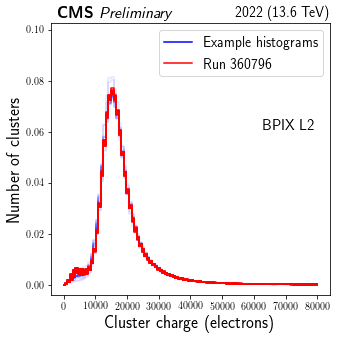

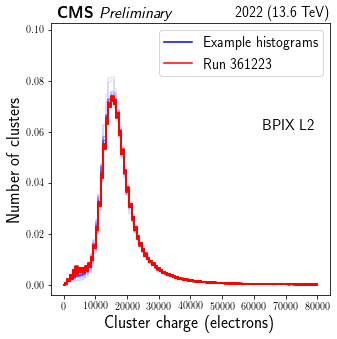

In [41]:
### make some plots

doplot = True

if doplot:
    
    index_mask = np.random.choice( np.arange(len(histstruct.get_lsnbs())), size=20, replace=False )
    if('random_plotting' in histstruct.masks.keys()): histstruct.remove_mask('random_plotting')
    histstruct.add_index_mask( 'random_plotting', index_mask )
    # bad test runs
    for badrun in badrunsls.keys():
        fig,axs = histstruct.plot_histograms( masknames=[['dcson','highstat','random_plotting'],['dcson','highstat','bad{}'.format(badrun)]],
                                labellist = ['Example histograms','Run {}'.format(badrun)],
                                colorlist = ['blue','red'],
                                transparencylist = [0.1,1.],
                                ncols=3,
                                opaque_legend=True,
                                titledict = titledict, titlesize=15,
                                extratextdict = extratextdict, extratextsize=15,
                                physicalxax = True,
                                xaxtitledict = xaxtitledict, xaxtitlesize=17,
                                yaxtitledict = yaxtitledict, yaxtitlesize=17,
                                ymaxfactor = 1.2,
                                legendsize = 14
                                )
        # stylistic modifications
        for ax in axs.reshape(-1):
            pu.add_cms_label( ax, pos=(0.02,1.01), extratext='Preliminary', fontsize=16 )
            pu.add_text( ax, '2022 (13.6 TeV)', (1,1.01), fontsize=14, horizontalalignment='right' )
        fig.subplots_adjust(wspace=0.3, hspace=0.3)
    histstruct.remove_mask('random_plotting')

As you can see in the figures above, **the red histograms deviate somewhat from the regularly expected shape (in blue)**, in the form of a (small) second peak at a charge of about 5000 electrons. These are rather subtle differences, but as we will see, even a vanilla autoencoder does a reasonably good job in recognizing these anomalies. **Whether these anomalies are actually problematic for the data quality is a different question, that needs to be discussed with tracker experts**; the only purpose of this exercise is to find any kind of anomalous behaviour.

**The cell below finally defines and trains autoencoders using keras/tensorflow**. They are deliberatly kept very simple in order not to overfit to the training data (potentially containing anomalies) and instead learn only the general behaviour of the good monitoring elements. See [here](https://github.com/LukaLambrecht/ML4DQMDC-PixelAE/blob/6326a7a7efcf5a50347bbd3a830823b2a816156b/utils/autoencoder_utils.py#L408) and [here](https://github.com/LukaLambrecht/ML4DQMDC-PixelAE/blob/6326a7a7efcf5a50347bbd3a830823b2a816156b/utils/autoencoder_utils.py#L373) for the actual definition of the model and training parameters in keras.

building Autoencoder model for histogram type PixelPhase1/Tracks/PXBarrel/charge_PXLayer_2
size of training set: (44253, 100)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_5 (Dense)              (None, 100)               5100      
Total params: 10,150
Trainable params: 10,150
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
20/20 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 3.2171e-04
Epoch 2/20
20/20 [==============================] - 0s 7ms/step - loss: 8.5179e-05 - val_loss: 2.8634e-05
Epoch 3/20
20/20 [==============================] - 0s 5ms/step - loss: 1.7658e-05 - val_loss: 1.8799e-05
Epoch 4/20
20/20 [==============================] - 0s 5ms/step - loss: 

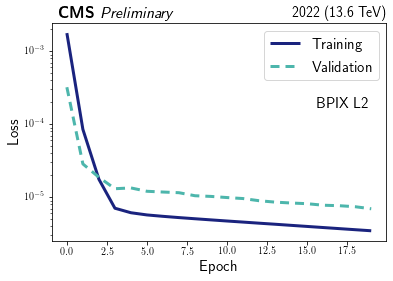

Epoch 1/20
200/200 [==============================] - 0s 2ms/step - loss: 2.9682e-06 - val_loss: 4.9497e-06
Epoch 2/20
200/200 [==============================] - 0s 2ms/step - loss: 2.1096e-06 - val_loss: 3.2294e-06
Epoch 3/20
200/200 [==============================] - 0s 2ms/step - loss: 1.5126e-06 - val_loss: 2.2074e-06
Epoch 4/20
200/200 [==============================] - 0s 2ms/step - loss: 1.1253e-06 - val_loss: 1.5074e-06
Epoch 5/20
200/200 [==============================] - 0s 2ms/step - loss: 8.6602e-07 - val_loss: 9.7891e-07
Epoch 6/20
200/200 [==============================] - 0s 2ms/step - loss: 6.8996e-07 - val_loss: 9.1122e-07
Epoch 7/20
200/200 [==============================] - 0s 2ms/step - loss: 6.4122e-07 - val_loss: 6.1364e-07
Epoch 8/20
200/200 [==============================] - 0s 2ms/step - loss: 5.2585e-07 - val_loss: 5.0580e-07
Epoch 9/20
200/200 [==============================] - 0s 2ms/step - loss: 4.7660e-07 - val_loss: 4.9003e-07
Epoch 10/20
200/200 [=======

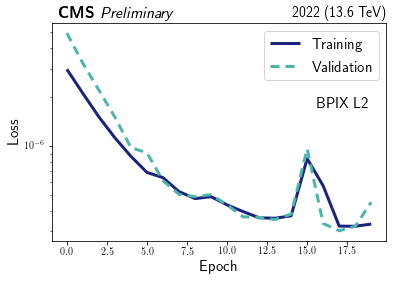

adding model "autoencoder" to the HistStruct


In [42]:
### define and train an autoencoder for each element

# loop over all the histogram types
# (however, in this case we have only one type of histogram)
classifiers = {}
for histname in histstruct.histnames:
    # for each histogram type (but again, there is only one in this simple case),
    # train an autoencoder on this specific set of histograms
    print('building Autoencoder model for histogram type {}'.format(histname))
    # first we get the histograms on which we want to train,
    # i.e. all histograms that are in the DCS-only json file 
    # and that have a sufficiently large number of entries 
    hists = histstruct.get_histograms(histname=histname, masknames=['dcson','highstat'])
    print('size of training set: {}'.format(hists.shape))
    # train the keras/tensorflow model
    # (the function below is just a simple wrapper to define and train a vanilla autoencoder in keras/tensorflow;
    #  feel free to replace it by your own architecture definition and training parameters)
    (kmodel, history) = aeu.train_simple_autoencoder(hists,
                        nepochs=20, batch_size=2000, shuffle=True,
                        returnhistory=True)
    # make a loss plot
    fig,ax = pu.plot_loss(history, xaxtitlesize=15, yaxtitlesize=15, legendsize=15, doshow=False)
    pu.add_cms_label( ax, pos=(0.02,1.01), extratext='Preliminary', fontsize=16 )
    pu.add_text( ax, '2022 (13.6 TeV)', (1,1.01), fontsize=14, horizontalalignment='right' )
    pu.add_text( ax, extratextdict[histname], (0.95,0.6), fontsize=15, horizontalalignment='right' )
    plt.show()
    # second training with smaller batch size
    history2 = kmodel.fit(hists, hists, epochs=20, batch_size=200,
                shuffle=True, verbose=1, validation_split=0.1)
    # make another loss plot
    fig,ax = pu.plot_loss(history2, xaxtitlesize=15, yaxtitlesize=15, legendsize=15, doshow=False)
    pu.add_cms_label( ax, pos=(0.02,1.01), extratext='Preliminary', fontsize=16 )
    pu.add_text( ax, '2022 (13.6 TeV)', (1,1.01), fontsize=14, horizontalalignment='right' )
    pu.add_text( ax, extratextdict[histname], (0.95,0.6), fontsize=15, horizontalalignment='right' )
    plt.show()
    # wrap the keras/tensorflow model in a custom AutoEncoder class
    # (just technical, for easier integration when using different classifiers instead of autoencoders)
    classifiers[histname] = AutoEncoder( model=kmodel ) 
            
# formally define the model and add it to the HistStruct object
model = ModelInterface(histstruct.histnames) 
model.set_classifiers(classifiers)
modelname = 'autoencoder'
histstruct.add_model( modelname, model )

In [43]:
### evaluate the classifiers on all histograms in the histstruct

histstruct.evaluate_classifiers( modelname )

Now that the model is trained and its output score calculated for all histograms, we can start evaluating the model performance. **The mean-squared-error (MSE) between an original histogram and its autoencoder reconstruction is a measure for anomalousness: we expect good histograms to be well reconstructed and therefore have a low MSE, while for anomalous histograms we expect a poor reconstruction and therefore a higher MSE.**  

As an additional step, the cell below inverts the MSE scores (called `IdentityFitter` in the code below). This is not strictly needed, but it is a relic of working with multiple types of monitoring elements simultaneously and with different individual classifiers, where it is easier to work with something that can be interpreted as a density, i.e. good histograms at high values and anomalous histograms at low values. Don't worry too much about this technical complication, just think of the MSE between a histogram and its autoencoder reconstruction as a measure for anomalousness

In [44]:
### train a fitter
# (this is not strictly needed when using only one type of monitoring element as we do here,
#  but just needed for a uniform syntax;
#  what this cell does is to take the MSEs and consider them as a measure for anomalousness)
print('Training identity fitter')
histstruct.set_fitter( modelname, IdentityFitter() )
histstruct.train_fitter( modelname, masknames=['dcson', 'highstat'] )
histstruct.evaluate_fitter( modelname )

Training identity fitter


In one of the cells above, the part of the test set with bad/anomalous lumisections has already been defined, but we do not have good lumisections for testing yet. There are several ways to define a good part of the test set, all having particular benefits and disadvantages. The most straightforward one is to simply pick a number of runs/lumisections that look ok on the plots. However, here we choose the different approach of **using the training set as the good part of the test set (excluding however the runs that are in the bad test set).** This has the advantage that we are not potentially biasing ourselves towards a specific hand-picked 'good' scenario, but on the other hand some anomalies might still be present in the 'good' test set. A more involved definition is needed for reliable outcomes, but for this exercise it is fine to simply ignore the (small) fraction of remaining anomalies that might still be present in the 'good' test set.

In [45]:
### define a good test set

goodmasknames=['dcson', 'highstat', 'notbad']

In [46]:
### extract the output scores for good and bad sets
    
# get the log probability for good set
prob_good = histstruct.get_globalscores( modelname, masknames=goodmasknames )
logprob_good = np.log(prob_good)

# get the log probability for bad set
prob_bad = histstruct.get_globalscores( modelname, masknames=['dcson','highstat','bad'] )
logprob_bad = np.log(prob_bad)

# define labels
labels_good = np.zeros(len(logprob_good)) # good = background = label 0
labels_bad = np.ones(len(logprob_bad)) # anomalous = signal = label 1

# concatenate scores and labels
labels = np.concatenate((labels_good,labels_bad))
scores = np.concatenate((-logprob_good,-logprob_bad))
scores = aeu.clip_scores( scores )

We will make a few plots to assess the model performance in the cells below.

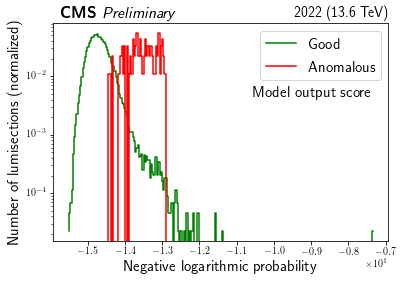

In [47]:
### plot the score distributions for good and anomalous histograms
fig,ax = pu.plot_score_dist(scores, labels, 
                   siglabel='Anomalous', sigcolor='r', 
                   bcklabel='Good', bckcolor='g', 
                   nbins=250, normalize=True,
                   xaxtitle='Negative logarithmic probability', xaxtitlesize=15,
                   yaxtitle='Number of lumisections (normalized)', yaxtitlesize=15,
                   legendsize=15,
                   doshow=False)
ax.set_yscale('log')
pu.add_cms_label( ax, pos=(0.02,1.01), extratext='Preliminary', fontsize=16 )
pu.add_text( ax, 'Model output score', (0.95,0.65), fontsize=15, horizontalalignment='right' )
pu.add_text( ax, '2022 (13.6 TeV)', (1,1.01), fontsize=14, horizontalalignment='right' )
plt.show()

In the plot above, you can see the distribution of the **model output scores for all lumisections, split between what we defined as 'good' lumisections (in green) and 'bad/anomalous' lumisections (in red).** Don't worry too much about the x-axis scaling; the point is that anomalous lumisections are on average situated at higher values (think of it as MSE, as before) than good lumisections. This means that by using a threshold value, we can separate the good from the anomalous lumisections pretty well. This is investigated in more detail by making a ROC plot in the cell below.

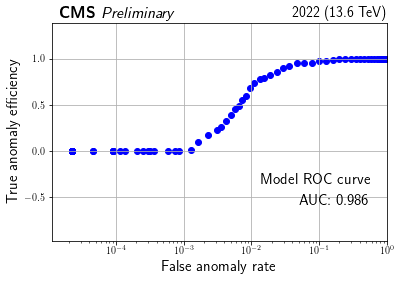

In [48]:
### plot ROC curve
(auc,sigeff,bkgeff,_) = aeu.get_roc(scores, labels, mode='geom', doprint=False, doplot=False, returneffs=True)
fig,ax = pu.plot_roc( sigeff, bkgeff,
                      xaxtitle='False anomaly rate', xaxtitlesize=15,
                      yaxtitle='True anomaly efficiency', yaxtitlesize=15, doshow=False
                       )
auctext = '{:.3f}'.format(auc)
if auc>0.99: auctext = '1 - '+'{:.3e}'.format(1-auc)
pu.add_cms_label( ax, pos=(0.02,1.01), extratext='Preliminary', fontsize=16 )
pu.add_text( ax, '2022 (13.6 TeV)', (1,1.01), fontsize=14, horizontalalignment='right' )
pu.add_text( ax, 'Model ROC curve', (0.95,0.25), fontsize=15, horizontalalignment='right' )
pu.add_text( ax, 'AUC: {}'.format(auctext), (0.95,0.15), fontsize=15, horizontalalignment='right' )
plt.show()

In the plot above, the x-axis shows the **false anomaly rate**, i.e. which fraction of good histograms is above the threshold and hence considered to be anomalous, and the y-axis shows the **true anomaly efficiency**, i.e. which fraction of anomalous histograms is above the threshold en hence correctly recognized. The AUC-value is the area under the ROC curve, which is a metric for model performance and should be as close to 1 as possible.

**Discussion**

**The AUC score we found is good, but not good enough**. For example, we could define a working point where the method spots only about 75% of all real anomalies ('true anomaly efficiency' = 0.75), with at the same time a false alarm rate of about 1% ('false anomaly rate' = 0.01). Given the small number of real anomalies with respect to good lumisections, this working point is not really satisfactory. There are however reasons to be optimistic:
- We used a **very simple method to obtain an already decent AUC**. Many improvements can be thought of, such as automatic filtering / outlier removal to clean the training set before training the autoencoder, optimizing the autoencoder architecture and parameters, etc.
- The **definition of 'good' lumisections** is likely too inclusive. We simply used all lumisections in the DCS-only json file that have a sufficient number of entries. The tail of the 'good' lumisections that overlaps with the anomalous lumisections in the score distribution plot above might very well (and probably does) contain lumisections that are at least equally anomalous as those in the 'anomalous' test set. More investigation is needed to define more accurate labels, but this is outside the scope of this exercise.
- The anomalies chosen in this exercise to test the method are rather subtle ones, even hard to spot by eye. It can be shown that this vanilla method already works **much better for more pronounced anomalies**.

This is the end of the exercise, but feel free to play with this notebook and the code it imports to try to get a better and/or more reliable separation between good and anomalous lumisections!

**Epilogue**

This exercise demonstrated the very basics of machine learning for DQM and/or DC, specifically for the pixel tracker. **The work in this field is however far from over**! There's still an exciting way to go from initial studies to something that works in production. Interesting? There is plenty to be tried and investigated. Get in touch with us:
- Gabriele Benelli (@gbenelli on Mattermost), coordinating Pixel ML4DQM.
- Antonio Vagnerini (@avagneri on Mattermost), DQM-DC convener involved in ML4DQM.